In [634]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from skimage import data, img_as_float
from skimage import exposure

In [635]:
params = 4
at = 3
ph = 2
dk = 0

n_pixels = 256
pixel_size = 55/1000 #mm
colormap = "bone"#"rainbow"



kernel_cold = np.ones((3,3))/(3*3)
kernel_hot = np.ones((3,3))/(3*3)
#def func(x, a, b, c):
    #return a*np.sin((2*np.pi/16)*x + b) + c

def func(x, a, b, c, d):
    return a*np.sin(b*x + c) + d


def fit(ilum_curves,i,j):
    xdata = np.arange(len(names))
    ydata = ilum_curves[i,j]
    popt, pcov = curve_fit(func, xdata, ydata, p0=Guess(ydata), maxfev=2000)
    #xdata_n = np.linspace(0,13,1000)
    #plt.plot(xdata_n, func(xdata_n, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    #plt.plot(xdata, ydata, "o")
    return popt

def Guess(curve):
    xvall=np.arange(len(curve))
    ff=np.fft.fftfreq(len(xvall), (xvall[1]-xvall[0]))
    Fyy = abs(np.fft.fft(np.array(curve)))
    guess_freq=2*np.pi*abs(ff[np.argmax(Fyy[1:])+1])
    return np.array([np.array(curve).std()*2**0.5, guess_freq, 0, np.array(curve).mean()])

def padding(image,size):
    rows, columns = np.shape(image)[0], np.shape(image)[1]
    padded_image = np.zeros((rows + 2*size, columns + 2*size))
    #padded_image[size:size+rows, size:size+columns] = image
    padded_image[size:-size, size:-size] = image
    return padded_image

def deppading(padded_image,size):
    return padded_image[size:-size, size:-size]

def reduce_dim(imagen, factor):
    filas, columnas = np.shape(imagen)[0], np.shape(imagen)[1]
    new_image = np.zeros((int(filas/factor), int(columnas/factor)))

    for i in range(0,filas,factor):
        for j in range(0,columnas,factor):
            new_image[int(i/factor),int(j/factor)] = np.mean(imagen[i:i+factor, j:j+factor])
    return new_image

           
def preparacion(imagen):
    filas, columnas = np.shape(imagen)[0], np.shape(imagen)[1]

    promedio = np.mean(imagen)
    new_imagen = imagen

    criterio_filas, criterio_columnas = (2.0/3.0)*filas, (2.0/3.0)*columnas

    for i in range(filas):
        if( np.count_nonzero(imagen[i,:]) <  criterio_filas):
            new_imagen[i,:] = promedio*np.ones(filas)
    
    for j in range(columnas):
        if( np.count_nonzero(imagen[:,j]) < criterio_columnas ):
            new_imagen[:,j] = promedio*np.ones(columnas)
    return new_imagen


def interp(imagen):
    factor = 2

    x, y, z = [], [], [] # Creamos nuestros puntos "x", "y", "z"
    
    tamano_matriz = np.shape(imagen)
    filas, columnas = tamano_matriz[0], tamano_matriz[1]
    
    for i in range(filas):
        for j in range(columnas):
            x.append(i)
            y.append(j)
            z.append(imagen[i,j])
    
    x, y, z = np.array(x), np.array(y), np.array(z)
    
    # Aca ya tenemos nuestros datos x,y,z. Ahora solo queda interpolarlos.
    
    grid_x, grid_y = np.mgrid[0:filas-1:factor*filas*1j, 0:columnas-1:factor*columnas*1j] # Creamos la rejilla, tal como se hizo en el primer ejemplo de interpolación en 2D. En este caso exigimos que el nuevo tamaño de la imagen sea de 100x100 y se pone 0:9 dado que los valores de i y j varian desde 0 hasta 9 en principio.  
    
    #print("El tamaño de la matriz nueva será: ", np.shape(grid_x)) # Fijarse que el tamaño de la matriz si es el que queremos
    
    puntos_xy = np.vstack((x,y)).T # Hacemos este paso que ya se había explicado en el ejemplo previo
    
    imagen_nueva = griddata(puntos_xy, z, (grid_x, grid_y), method='cubic') # Hacemos interpolacion cúbica

    imagen_dim_reducida = reduce_dim(imagen_nueva, factor)

    return imagen_dim_reducida



def convolution(image,kernel_cold, kernel_hot, selective=False, stds_cold=1, stds_hot=1):
    excess_cold = int((np.shape(kernel_cold)[0] - 1)/2)
    excess_hot = int((np.shape(kernel_hot)[0] - 1)/2)

    n_pixels_kernel_cold = np.shape(kernel_cold)[0]*np.shape(kernel_cold)[1]
    acceptable_pixels_cold = ((np.shape(kernel_cold)[0]-1)/np.shape(kernel_cold)[0])*n_pixels_kernel_cold
    n_pixels_kernel_hot = np.shape(kernel_hot)[0]*np.shape(kernel_hot)[1]
    acceptable_pixels_hot = ((np.shape(kernel_hot)[0]-1)/np.shape(kernel_hot)[0])*n_pixels_kernel_hot

    mean_image, std_image = np.mean(image), np.std(image)

    minimum_acceptable = mean_image - stds_cold*std_image
    maximum_acceptable = mean_image + stds_hot*std_image
    print("minimum: " ,minimum_acceptable)
    print("maximum: " ,maximum_acceptable)

    if(selective==False):
        padded_image = padding(image,excess_cold)
        padded_rows, padded_columns = np.shape(padded_image)[0], np.shape(padded_image)[1]

        result = np.zeros( (padded_rows, padded_columns) )
        for i in range(excess_cold, padded_rows-excess_cold):
            for j in range(excess_cold, padded_columns-excess_cold):
                if(np.count_nonzero(padded_image[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]) > acceptable_pixels_cold):
                    multiplication = padded_image[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]*kernel_cold
                    result[i,j] = np.sum(multiplication)
                elif(np.count_nonzero(padded_image[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]) <= acceptable_pixels_cold):
                    imagen_interp = interp(padded_image[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1])
                    multiplication = imagen_interp*kernel_cold
                    result[i,j] = np.sum(multiplication)
        result = deppading(result,excess_cold)
        return result

    if(selective==True):

        padded_image_cold = padding(image,excess_cold)
        padded_rows_cold, padded_columns_cold = np.shape(padded_image_cold)[0], np.shape(padded_image_cold)[1]

        result = padded_image_cold
        for i in range(excess_cold, padded_rows_cold-excess_cold):
            for j in range(excess_cold, padded_columns_cold-excess_cold):
                if(result[i,j] <= minimum_acceptable and np.count_nonzero(padded_image_cold[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]) > acceptable_pixels_cold):
                    multiplication = padded_image_cold[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]*kernel_cold
                    result[i,j] = np.sum(multiplication)
                elif(result[i,j] <= minimum_acceptable and np.count_nonzero(padded_image_cold[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1]) <= acceptable_pixels_cold):
                    imagen_interp = interp(padded_image_cold[i-excess_cold:i+excess_cold+1, j-excess_cold:j+excess_cold+1])
                    multiplication = imagen_interp*kernel_cold
                    result[i,j] = np.sum(multiplication)

        result = deppading(result,excess_cold)

        padded_image_hot = padding(result,excess_hot)
        padded_rows_hot, padded_columns_hot = np.shape(padded_image_hot)[0], np.shape(padded_image_hot)[1]

        result2 = padded_image_hot

        for i in range(excess_hot, padded_rows_hot-excess_hot):
            for j in range(excess_hot, padded_columns_hot-excess_hot):
                if(result2[i,j] >= maximum_acceptable and np.count_nonzero(padded_image_hot[i-excess_hot:i+excess_hot+1, j-excess_hot:j+excess_hot+1]) > acceptable_pixels_hot):
                    multiplication = padded_image_hot[i-excess_hot:i+excess_hot+1, j-excess_hot:j+excess_hot+1]*kernel_hot
                    result2[i,j] = np.sum(multiplication)
                elif(result2[i,j] >= maximum_acceptable and np.count_nonzero(padded_image_hot[i-excess_hot:i+excess_hot+1, j-excess_hot:j+excess_hot+1]) <= acceptable_pixels_hot):
                    imagen_interp = interp(padded_image_hot[i-excess_hot:i+excess_hot+1, j-excess_hot:j+excess_hot+1])
                    multiplication = imagen_interp*kernel_hot
                    result2[i,j] = np.sum(multiplication)

        result2 = deppading(result2,excess_hot)
        return result2

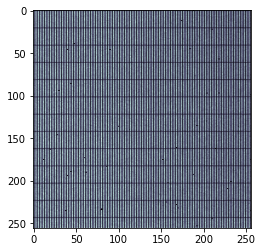

In [636]:
images = []

names = ["FF_cilindroM6.txt", "FF_cilindroM5.txt", "FF_cilindroM4.txt", "FF_cilindroM3.txt", "FF_cilindroM2.txt", "FF_cilindroM1.txt", "FF_cilindro0.txt", 
"FF_cilindroP1.txt", "FF_cilindroP2.txt", "FF_cilindroP3.txt", "FF_cilindroP4.txt", "FF_cilindroP5.txt", "FF_cilindroP6.txt"]

for name in names:
    #img = np.rot90(np.genfromtxt("1. RAW/"+ name),1)
    img = np.rot90(np.genfromtxt("2. FF/"+ name),1)
    images.append(img)

images = np.array(images)
plt.imshow(images[3], cmap="bone")

In [637]:
for img in images: 
    mean = np.mean(img)
    for i in range(256):
        for j in range(256):
            if img[i,j] == 0:
                img[i,j] = mean

In [638]:
def profile_pixel(images,i,j):
    points = []
    for image in images:
        points.append(image[i,j])
    return points

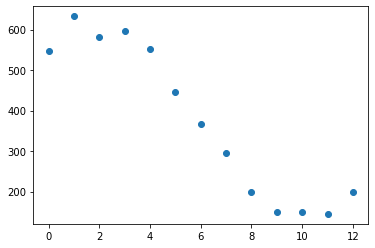

In [639]:
plt.plot(profile_pixel(images,0,0), "o")

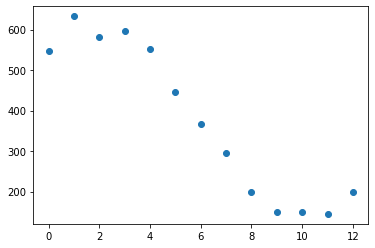

In [640]:
ilum_curves_nosample = []

for i in range(256):
    for j in range(256):
        ilum_curves_nosample.append(profile_pixel(images,i,j))

ilum_curves_nosample = np.array(ilum_curves_nosample)
ilum_curves_nosample = ilum_curves_nosample.reshape((256,256,len(names)))

plt.plot(ilum_curves_nosample[0,0], "o")

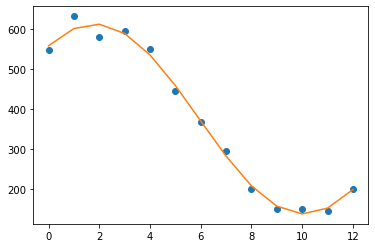

In [641]:
xdata = np.arange(len(names))

plt.plot(ilum_curves_nosample[0,0], "o")
plt.plot(xdata, func(xdata, *fit(ilum_curves_nosample,0,0)))

In [642]:
datos_fits = []

for i in range(256):
    for j in range(256):
        datos_fits.append(fit(ilum_curves_nosample,i,j))

datos_fits = np.array(datos_fits)
datos_fits = datos_fits.reshape((256,256,params)) # numero de parametros de ajuste = 3


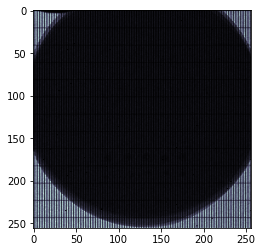

In [643]:
images_sample = []
names = ["RAW_cilindroM6.txt", "RAW_cilindroM5.txt", "RAW_cilindroM4.txt", "RAW_cilindroM3.txt", "RAW_cilindroM2.txt", "RAW_cilindroM1.txt", "RAW_cilindro0.txt", 
"RAW_cilindroP1.txt", "RAW_cilindroP2.txt", "RAW_cilindroP3.txt", "RAW_cilindroP4.txt", "RAW_cilindroP5.txt", "RAW_cilindroP6.txt"]

for name in names:
    #img = np.rot90(np.genfromtxt("1. RAW/"+ name),1)
    img = np.rot90(np.genfromtxt("1. RAW/"+ name),1)
    images_sample.append(img)

images_sample = np.array(images_sample)
plt.imshow(images_sample[3], cmap="bone")

In [644]:
for img in images_sample: 
    mean = np.mean(img)
    for i in range(256):
        for j in range(256):
            if img[i,j] == 0:
                img[i,j] = mean

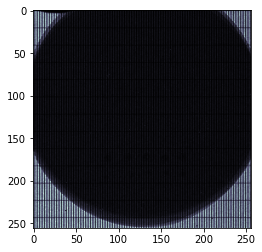

In [645]:
plt.imshow(images_sample[3], cmap="bone")

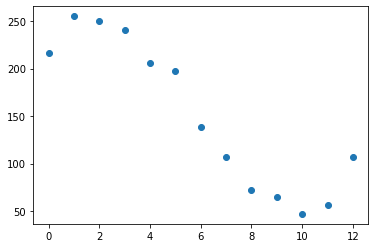

In [646]:
ilum_curves_sample = []

for i in range(256):
    for j in range(256):
        ilum_curves_sample.append(profile_pixel(images_sample,i,j))

ilum_curves_sample = np.array(ilum_curves_sample)
ilum_curves_sample = ilum_curves_sample.reshape((256,256,len(names)))

plt.plot(ilum_curves_sample[0,0], "o")

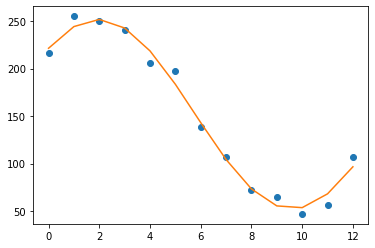

In [647]:
xdata = np.arange(len(names))

plt.plot(ilum_curves_sample[0,0], "o")
plt.plot(xdata, func(xdata, *fit(ilum_curves_sample,0,0)))

In [648]:
datos_fits_s = []

for i in range(256):
    for j in range(256):
        datos_fits_s.append(fit(ilum_curves_sample,i,j))

datos_fits_s = np.array(datos_fits_s)
datos_fits_s = datos_fits_s.reshape((256,256,params)) # numero de parametros de ajuste = 3

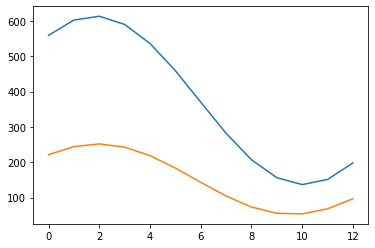

In [649]:
xdata = np.arange(len(names))

plt.plot(xdata, func(xdata, *datos_fits[0,0,:]))
plt.plot(xdata, func(xdata, *datos_fits_s[0,0,:]))

In [664]:
print(datos_fits_s[:,:,1])

[[0.41037882 0.35743137 0.39934898 ... 0.37784227 0.38157626 0.38220265]
 [0.39766607 0.38260226 0.39282573 ... 0.38348525 0.3784582  0.35990358]
 [0.37833195 0.39400078 0.38429096 ... 0.38125505 0.36958923 0.38914246]
 ...
 [0.38394666 0.37578393 0.38022682 ... 0.36640907 0.37725766 0.39634968]
 [0.39800356 0.37896775 0.38212729 ... 0.38376803 0.34549301 0.39098745]
 [0.36900319 0.3687362  0.37603727 ... 0.38544911 0.35865717 0.40482167]]


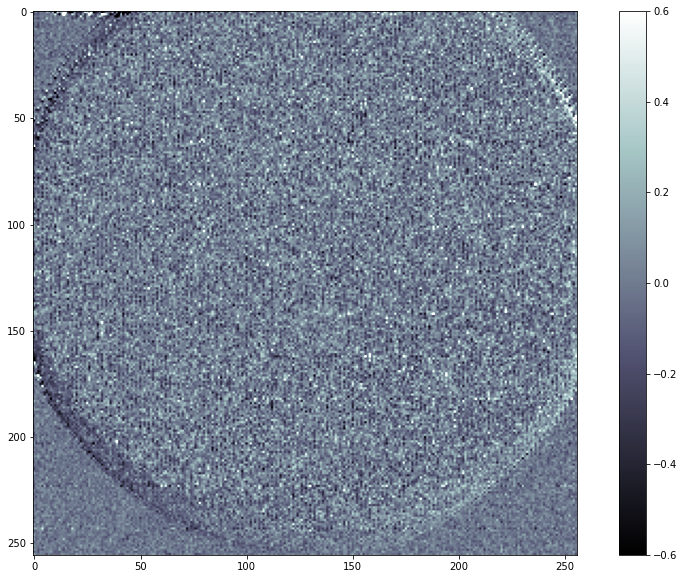

In [650]:
plt.figure(figsize=(15,10))
phase_tot = datos_fits_s[:,:,ph] - datos_fits[:,:,ph]
plt.imshow(phase_tot, cmap="bone", vmin=-0.6, vmax=0.6)
plt.colorbar()

(array([  19.,   29.,   40.,   60.,   64.,  124.,  132.,  168.,  236.,
         283.,  390.,  502.,  604.,  741.,  927., 1196., 1443., 1744.,
        2152., 2457., 2997., 3585., 3792., 4198., 4311., 4319., 4117.,
        3781., 3452., 3070., 2628., 2165., 1830., 1570., 1247.,  993.,
         825.,  629.,  505.,  427.,  327.,  289.,  175.,  188.,  148.,
          86.,   95.,   69.,   67.,   48.]),
 array([-0.6  , -0.576, -0.552, -0.528, -0.504, -0.48 , -0.456, -0.432,
        -0.408, -0.384, -0.36 , -0.336, -0.312, -0.288, -0.264, -0.24 ,
        -0.216, -0.192, -0.168, -0.144, -0.12 , -0.096, -0.072, -0.048,
        -0.024,  0.   ,  0.024,  0.048,  0.072,  0.096,  0.12 ,  0.144,
         0.168,  0.192,  0.216,  0.24 ,  0.264,  0.288,  0.312,  0.336,
         0.36 ,  0.384,  0.408,  0.432,  0.456,  0.48 ,  0.504,  0.528,
         0.552,  0.576,  0.6  ]),
 <BarContainer object of 50 artists>)

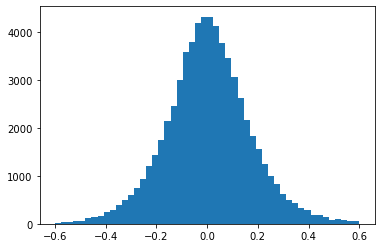

In [651]:
plt.hist(np.ravel(phase_tot), bins=50, range=(-0.6,0.6))

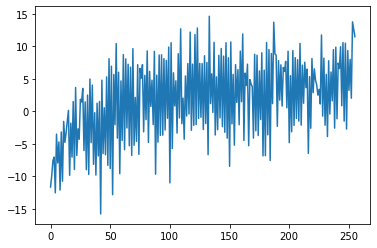

In [652]:
perfiles = phase_tot[0,:]
for i in range(1,256): 
    perfiles += phase_tot[i,:]

plt.plot(perfiles)

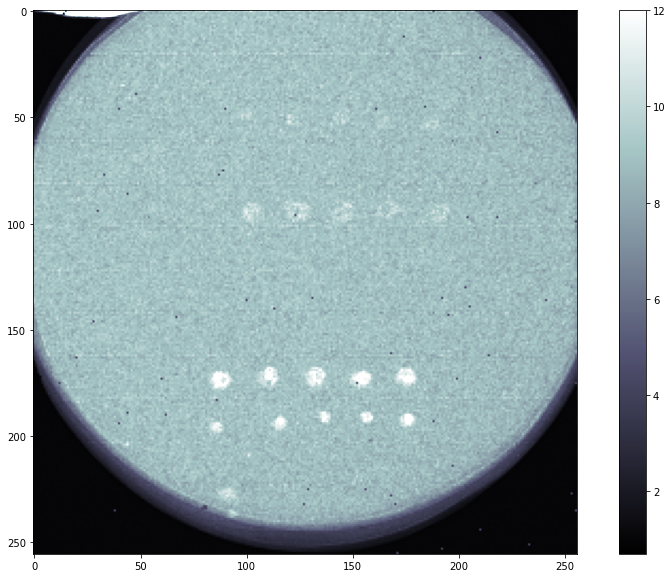

In [653]:
plt.figure(figsize=(15,10))
att = np.abs(datos_fits[:,:,at]/datos_fits_s[:,:,at])
plt.imshow(att, cmap="bone", vmin=0.7, vmax=12)
plt.colorbar()

minimum:  5.548177793004483
maximum:  12.001998291898198


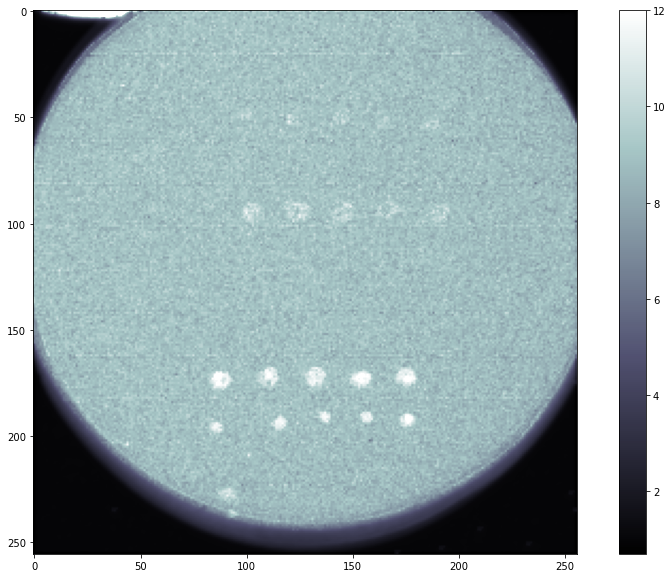

In [654]:
att2 = convolution(att, kernel_cold, kernel_hot, selective=True, stds_cold=0.5, stds_hot=1)
plt.figure(figsize=(15,10))
plt.imshow(att2, cmap="bone", vmin=0.7, vmax=12)
plt.colorbar()

(array([  175.,  7486.,    96.,   112.,   162.,   317.,   220.,   162.,
          153.,   144.,   168.,   253.,   313.,   308.,   249.,   239.,
          146.,   108.,    75.,    95.,   147.,   144.,   118.,   128.,
          105.,   104.,    97.,   119.,   149.,   207.,   397.,   806.,
         1883.,  3937.,  6855.,  9410., 10298.,  8530.,  5516.,  2854.,
         1374.,   529.,   236.,   100.,    77.,    59.,    42.,    43.,
           50.,    33.]),
 array([ 0.7  ,  0.926,  1.152,  1.378,  1.604,  1.83 ,  2.056,  2.282,
         2.508,  2.734,  2.96 ,  3.186,  3.412,  3.638,  3.864,  4.09 ,
         4.316,  4.542,  4.768,  4.994,  5.22 ,  5.446,  5.672,  5.898,
         6.124,  6.35 ,  6.576,  6.802,  7.028,  7.254,  7.48 ,  7.706,
         7.932,  8.158,  8.384,  8.61 ,  8.836,  9.062,  9.288,  9.514,
         9.74 ,  9.966, 10.192, 10.418, 10.644, 10.87 , 11.096, 11.322,
        11.548, 11.774, 12.   ]),
 <BarContainer object of 50 artists>)

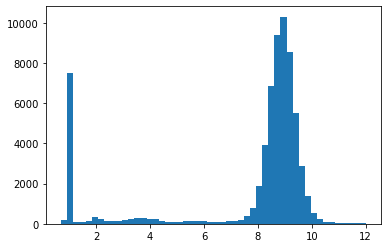

In [655]:
plt.hist(np.ravel(att), bins=50, range=(0.7,12))

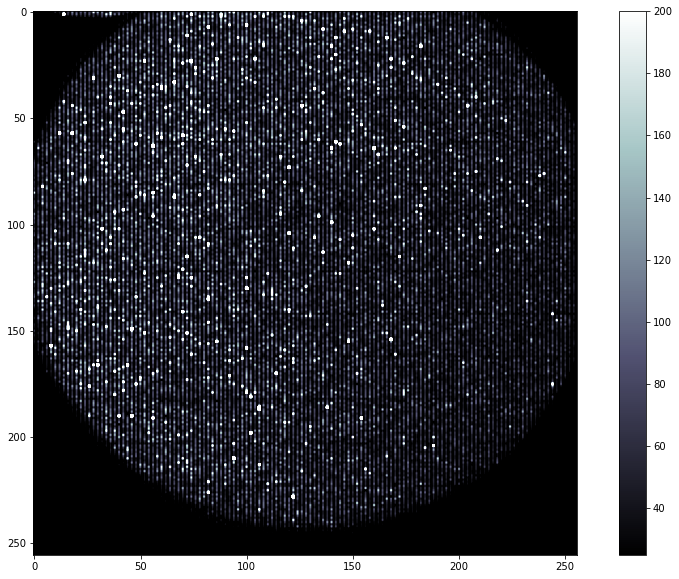

In [663]:
plt.figure(figsize=(15,10))
dark = np.abs(datos_fits_s[:,:,dk]-datos_fits[:,:,at])/np.abs(datos_fits_s[:,:,dk]-datos_fits_s[:,:,at])
plt.imshow(dark, cmap="bone", vmin=25, vmax=200)
plt.colorbar()

(array([ 155.,  157.,  188.,  347.,  579.,  850., 1156., 1425., 1580.,
        1621., 1699., 1686., 1471., 1398., 1291., 1153., 1042.,  947.,
         797.,  773.,  678.,  567.,  530.,  462.,  405.,  364.,  342.,
         299.,  247.,  233.,  225.,  171.,  170.,  123.,  118.,  122.,
         121.,  121.,   87.,   94.,   72.,   67.,   81.,   53.,   43.,
          53.,   48.,   41.,   50.,   33.]),
 array([ 25. ,  28.5,  32. ,  35.5,  39. ,  42.5,  46. ,  49.5,  53. ,
         56.5,  60. ,  63.5,  67. ,  70.5,  74. ,  77.5,  81. ,  84.5,
         88. ,  91.5,  95. ,  98.5, 102. , 105.5, 109. , 112.5, 116. ,
        119.5, 123. , 126.5, 130. , 133.5, 137. , 140.5, 144. , 147.5,
        151. , 154.5, 158. , 161.5, 165. , 168.5, 172. , 175.5, 179. ,
        182.5, 186. , 189.5, 193. , 196.5, 200. ]),
 <BarContainer object of 50 artists>)

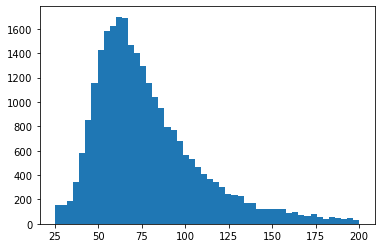

In [662]:
plt.hist(np.ravel(dark), bins=50, range=(25,200))